## In this notebook: Fig 

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use("article.mplstyle")
import pandas as pd
import seaborn as sns

import mne

import glob
import os
import sys
from scipy.io import savemat, loadmat
from scipy.stats import pearsonr, spearmanr, sem, wilcoxon, ttest_ind
from statsmodels.stats.multitest import fdrcorrection
import scipy.stats as stats
from pingouin import rm_anova

from statannotations.Annotator import Annotator


sys.path.append('../utils')
from ERP_utils import *
from update_sub_lists import*
mne.set_log_level('CRITICAL')

### Set up 

In [43]:
#plotting parameters
firsts_color = 'teal'
others_color = 'coral'

figs_dir = './figures'


plt.style.use("article.mplstyle")

# axis_fontsize = 20
# xtick_fontsize = 15

In [44]:
#-----------------------------
#           LOADING FILES AND INITIALIZING DIRECTORIES
#-----------------------------

#use MIDI folders or audio folders to change triggers
epochs_dir = '../analysis_error/error_epochs_data_n05to05_30Hz_corrected'


#channels and times for plotting
# ch_names_64, ch_names_72 = load_channels()
erp_times = create_erp_times(-0.5,0.5, 128)

good_listen_subjects, good_motor_subjects, good_error_subjects, musicians, nonmusicians = load_subject_lists_LME()
subjects_to_process =  good_error_subjects

In [45]:
def load_error_epochs_bysubject(epochs_dir, subjects_to_process, epoch_type, sub_ave = True):
    """ 
    Loads the epochs for error trials
    subjects_to_process: list of subjects where each element is a string. e.g. ['01', '02']
    epoch_type: which error keystrokes are included. Currently 'all', 'inv', 'shinv' and 'norm'
        ---future: separate keystrokes that are the first keystroke after a map change from all the other keystrokes
    ---
    Returns a dataframe with columns 'subject', 'period', 'musician', and 'epoch_type'.
        each row of ['epochs'] is an array of shape n_channels x n_timepoints, and is the average of all epochs from one subject
    
    """

    epochs_df = pd.DataFrame(columns = ['subject', 'period', 'musician', 'epochtype', 'epochs'])
    good_listen_subjects, good_motor_subjects, musicians, nonmusicians = load_subject_lists()

    assert isinstance (subjects_to_process, list)

    for subject in subjects_to_process:
        print('Processing subject: ', subject)

        if subject in musicians: 
            musician = 1
        else: 
            musician = 0
        for period in ['pre', 'post']:
            file_epochs_pre = glob.glob(os.path.join(epochs_dir, f'error_epochs_{epoch_type}_{period}_{subject}.fif'))[0]
            epochs_sub = mne.read_epochs(file_epochs_pre)

            if sub_ave:
                epochs_sub = np.mean(epochs_sub.get_data()[:, :64, :], axis = 0) #get only the eeg channels and average all trials per subject
            else: 
                #epochs_sub = epochs_sub.get_data()[:, :64, :]
                epochs_sub = epochs_sub.get_data()

            df_sub = pd.DataFrame({
                'subject': subject,
                'period' : period,
                'musician' : musician,
                'epochtype': epoch_type,
                'epochs': [epochs_sub]
            })
            epochs_df = pd.concat([epochs_df, df_sub])


    epochs_df.reset_index(drop=True, inplace=True)
    return (epochs_df)


In [46]:
# epochs_df_all = load_error_epochs_bysubject(epochs_dir, subjects_to_process, 'all')
# epochs_df_inv = load_error_epochs_bysubject(epochs_dir, subjects_to_process, 'inv')
# epochs_df_shinv = load_error_epochs_bysubject(epochs_dir, subjects_to_process, 'shinv')
# epochs_df_norm = load_error_epochs_bysubject(epochs_dir, subjects_to_process, 'norm')

epochs_df_firsts = load_error_epochs_bysubject(epochs_dir, subjects_to_process, 'firsts', sub_ave=False)
epochs_df_others = load_error_epochs_bysubject(epochs_dir, subjects_to_process, 'others', sub_ave=False)


Processing subject:  01
Processing subject:  04
Processing subject:  05
Processing subject:  06
Processing subject:  07
Processing subject:  08
Processing subject:  09
Processing subject:  10
Processing subject:  11
Processing subject:  12
Processing subject:  13
Processing subject:  14
Processing subject:  15
Processing subject:  16
Processing subject:  17
Processing subject:  18
Processing subject:  19
Processing subject:  20
Processing subject:  01
Processing subject:  04
Processing subject:  05
Processing subject:  06
Processing subject:  07
Processing subject:  08
Processing subject:  09
Processing subject:  10
Processing subject:  11
Processing subject:  12
Processing subject:  13
Processing subject:  14
Processing subject:  15
Processing subject:  16
Processing subject:  17
Processing subject:  18
Processing subject:  19
Processing subject:  20


In [47]:
epochs_df_firsts['evokeds'] = epochs_df_firsts['epochs'].apply(lambda x: np.mean(x, axis=0))
epochs_df_others['evokeds'] = epochs_df_others['epochs'].apply(lambda x: np.mean(x, axis=0))

## Stats test on subset epochs (bootstrapping etc)

In [48]:
def subset_epochs(epochs_df, n_epochs, ave = False):
    if ave:
        epochs_sub = np.mean([epoch[np.random.choice(epoch.shape[0], n_epochs, replace=True), :, :]
                                        for epoch in epochs_df['epochs']], axis = 1)
    else:
        epochs_sub =[epoch[np.random.choice(epoch.shape[0], n_epochs, replace=True), :, :]
                                        for epoch in epochs_df['epochs']]

    epochs_df_new = epochs_df.copy()

    epochs_df_new['epochs'] = [epochs_sub[i] for i in range(epochs_df.shape[0])]

    return epochs_df_new

def ci95(arr, axis):
    lower_bound = np.percentile(arr, 2.5, axis = axis)
    upper_bound = np.percentile(arr, 97.5, axis = axis)

    return lower_bound, upper_bound

In [49]:
# n_iter = 200
# n_samp = 100
# time_to_plot = 0.1

# diffs_fo_boot = []

# for i in range(n_iter):

#     #subset epochs
#     epochs_df_firsts_sub = subset_epochs(epochs_df_firsts, n_samp)
#     epochs_df_others_sub = subset_epochs(epochs_df_others, n_samp)

#     #take average for each subject
#     epochs_df_firsts_sub['evokeds'] =  epochs_df_firsts_sub['epochs'].apply(lambda x: np.mean(x, axis=0)) 
#     epochs_df_others_sub['evokeds'] = epochs_df_others_sub['epochs'].apply(lambda x: np.mean(x, axis = 0))

#     #calculate diff between first and others
#     df_diff_sub = epochs_df_firsts_sub[['subject', 'period']].copy()
#     df_diff_sub['diff'] = epochs_df_firsts_sub['evokeds'] - epochs_df_others_sub['evokeds']

#     time_idx = time_index_custom([time_to_plot], erp_times)
#     period = 'pre'
#     diffs_fo_sub = np.stack(df_diff_sub.query(f"period =='{period}'")['diff'].values)[:, :64, time_idx].squeeze()

#     diffs_fo_boot.append(diffs_fo_sub)

# diffs_fo_boot = np.stack(diffs_fo_boot)
# #_, p_fo = t_over_channels(diffs_fo_sub)
# diffs_fo_boot_mean = np.mean(diffs_fo_boot, axis = 1)



In [50]:
def bootstrap_fo_diffs(epochs_df_1, epochs_df_2, period, time_to_plot, n_iter = 200, n_samp = 100):
    """ 
    epochs_df_1, epochs_df_2:epochs to compare.Dataframe with columns 'subject', 'period', 'musician', 'epochtype', 'epochs'
    period: 'pre' or 'post' training
    time_to_plot: timepoint to bootstrap
    n_iter: number of bootstrap iterations
    n_samp: number of epochs from each epoch df to sample for each iteration
    ---
    Returns: distribution of means of the bootstrapped differences between epochs_df_1 and epochs_df_2 at all channels
        shape n_iter x n_channels
    """

    diffs_fo_boot = []

    for i in range(n_iter):

        #take a random sample of epochs from each df
        epochs_df_firsts_sub = subset_epochs(epochs_df_1, n_samp)
        epochs_df_others_sub = subset_epochs(epochs_df_2, n_samp)

        #find the mean of each sample
        epochs_df_firsts_sub['evokeds'] =  epochs_df_firsts_sub['epochs'].apply(lambda x: np.mean(x, axis=0)) 
        epochs_df_others_sub['evokeds'] = epochs_df_others_sub['epochs'].apply(lambda x: np.mean(x, axis = 0))

        #calculate diff between mean of firsts and mean of others
        df_diff_sub = epochs_df_firsts_sub[['subject', 'period']].copy()
        df_diff_sub['diff'] = epochs_df_firsts_sub['evokeds'] - epochs_df_others_sub['evokeds']

        #retain the time index of time_to_plot
        time_idx = time_index_custom([time_to_plot], erp_times)

        #isolate the rows of df for pre-training
        #extract diff values for each suject, retains the 64 EEG channels and the timepoint of interest
        diffs_fo_sub = np.stack(df_diff_sub.query(f"period =='{period}'")['diff'].values)[:, :64, time_idx].squeeze()
   

        diffs_fo_sub = np.atleast_2d(diffs_fo_sub) #accounts for the case where there is only one subject
        # print(diffs_fo_sub.shape)
        diffs_fo_boot.append(diffs_fo_sub)

    diffs_fo_boot = np.stack(diffs_fo_boot)
    diffs_fo_boot_mean = np.mean(diffs_fo_boot, axis = 1) #average over subjects over each iteration

    return diffs_fo_boot_mean


In [51]:
#plot bootstrap distribution (looking at pre-training only)
plot_bootstrap = False

if plot_bootstrap: #this takes a long time to run so only run if specified
    n_iter = 1000 #1000 
    n_samp = 100
    time_to_plot = 0.1
    # time_to_plot = 0.37
    period = 'pre'

    #first vs others bootstrap
    diffs_fo_boot_mean = bootstrap_fo_diffs(epochs_df_firsts, epochs_df_others, 
                                            period, 
                                            time_to_plot= time_to_plot, 
                                            n_iter = n_iter, 
                                            n_samp = n_samp)
    ci_l, ci_u = ci95(diffs_fo_boot_mean, axis = 0)


    #null distribution
    diffs_fo_boot_mean_null = bootstrap_fo_diffs(epochs_df_others, epochs_df_others, 
                                                period, 
                                                time_to_plot = time_to_plot, 
                                                n_iter = n_iter, 
                                                n_samp = n_samp)
    ci_l_null, ci_u_null = ci95(diffs_fo_boot_mean_null, axis = 0)

In [52]:
if plot_bootstrap:
    ch_to_plot = 'Fz'
    ch_idx = ch_index([ch_to_plot])
    n_bins = 25

    fig=plt.figure(figsize=(1.5, 0.4))
    ax = fig.add_axes([0,0,1,1]) 

    #plot hist
    counts_firsts, _, _= plt.hist(diffs_fo_boot_mean[:, ch_idx], bins = n_bins, color = 'green', label = 'firsts vs others', alpha = 0.5)
    counts_others, _, _ = plt.hist(diffs_fo_boot_mean_null[:, ch_idx], bins = n_bins, color = 'black', label = 'others vs others', alpha = 0.5)

    #plot CI95
    bar_ypos = max(np.max(counts_firsts), np.max(counts_others)) + 4 #position of the top of the bars
    bar_linewidth = 0.5
    bar_endwidth = 0.5

    #formatting for ci95
    bracketsize = 3
        #firsts CI95
    plt.hlines(bar_ypos, ci_l[ch_idx], ci_u[ch_idx], color = 'green', linewidth = bar_linewidth, alpha = 0.7)
    plt.vlines(ci_l[ch_idx], bar_ypos - bracketsize, bar_ypos + bracketsize, color = 'green', linewidth = bar_endwidth, alpha = 0.7)
    plt.vlines(ci_u[ch_idx], bar_ypos - bracketsize, bar_ypos + bracketsize, color = 'green',linewidth = bar_endwidth, alpha = 0.7)
        #others CI95
    plt.hlines(bar_ypos, ci_l_null[ch_idx], ci_u_null[ch_idx], color = 'black', linewidth = bar_linewidth, alpha = 0.7)
    plt.vlines(ci_l_null[ch_idx], bar_ypos - bracketsize, bar_ypos + bracketsize, color = 'black',linewidth = bar_endwidth, alpha = 0.7)
    plt.vlines(ci_u_null[ch_idx], bar_ypos - bracketsize, bar_ypos + bracketsize, color = 'black',linewidth = bar_endwidth, alpha = 0.7)

    #plot vertical line at 0
    plt.vlines(0, 0, bar_ypos, color = 'red', linestyle = '--')

    #plt.legend(fontsize = xtick_fontsize)
    plt.ylim(0, bar_ypos+10)
    # plt.xlabel('Mean difference ($\mu$V)')
    # plt.ylabel('Frequency')
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 1e6:.1f}'))  # Convert to µV
    plt.yticks([0, 120])
    plt.xticks([])
    plt.xlim(-2.3e-6, 1.1e-6)

    # plt.legend(fontsize = 7)
    # plt.title(f'firsts and others diff {time_to_plot}s, {ch_to_plot}, {n_samp} samples, {n_iter} bootstrap iters, {period}, sub{ subjects_to_process}')
    plt.savefig(f'./figures/bootstrap_fo_{ch_to_plot}_{time_to_plot}_{period}.svg')

## Plot channel differences

In [62]:
# ch_to_plot = 'FCz'
# ch_idx = ch_index([ch_to_plot])[0]
# period = 'post'


# plt.figure(figsize=(10,8))
# for sub in subjects_to_process:
#     plt.plot(erp_times, corr_df.query(f"sub == '{sub}' and period == '{period}' ")['diff'].values[0][ch_idx], label=sub, linewidth=0.5)

# #mean
# #diff_values = np.array([row[ch_idx] for row in df_diff['diff']])
# diff_values = np.array([row[ch_idx] for row in corr_df.query(f"period == '{period}'")['diff']])

# #diff_values = np.array([row[ch_idx] for row in corr_df.query(f"sub == '{sub}' and period == '{period}' ")['diff']])

# mean_diff = np.mean(diff_values, axis=0)
# sem_diff = np.std(diff_values, axis=0) / np.sqrt(diff_values.shape[0])

# plt.plot(erp_times, mean_diff, label='Mean', linewidth=1.5, color='red')

# #SEM
# sem_diff = np.std(diff_values, axis=0) / np.sqrt(diff_values.shape[0])
# plt.fill_between(
#     erp_times, 
#     mean_diff - sem_diff, 
#     mean_diff + sem_diff, 
#     color='red', 
#     alpha=0.17, 
#     label='SEM'
# )

# plt.plot()
# plt.legend()
# plt.title(f'First note after map change vs other notes, {period} training, {ch_to_plot}')
# #plt.vlines(time_to_plot, 0,4e-6, color = 'black')
# plt.hlines(0,-0.5,0.5, color = 'black')

## Fig 6G: Correlation with musicianship

In [54]:
def find_ev_diffs(df):
    """ 
    Takes prepared epochs dataframes from pre and post (or any other to compare )
    """
    df['evokeds'] = df['epochs'].apply(lambda x: np.mean(x, axis=0))

    df_diff = df.pivot(['period'])

    return df_diff

def diff_score_df(data_df, scores_df, sub_col_name, data_columns): 

    """ 
    combines the df with training scores and the df with some participant-specific data to allow corr analyses

    Note: subject is the unformatted column. sub is formatted as strings with leading 0s, e.g. '02'
    power_diff_df: expected columns: sub, diff
    scores_df: exported from training repo with scores from all subjects. Expected columns:  subject, score, musician, rank
    sub_col_name: name of subject column in data df (usually sub or subject)
    data_columns: columns from the data
    ---
    returns diff_df_ranked: df with sub, training score, data of interest, and relative ranking to other subjects
    """

    #configure sub column of scores_df to make it match the column in the diff df
    scores_df['sub'] = scores_df['subject'].astype(int).apply(lambda x: f'{x:02d}')

    #configure data df
    data_df['sub'] = data_df[sub_col_name]
    assert data_df['sub'].apply(lambda x: isinstance(x, str) and len(x) == 2).all(), "Subjects should be expressed as a string with 2 characters"

    data_filt_df = data_df[['sub'] + data_columns]
    data_filt_df.reset_index(drop=True)

    diff_df_ranked = data_filt_df.merge(scores_df, on =['sub'])
    #power_diff_df_ranked = power_diff_df_ranked[['sub', 'diff', 'musician', 'score', 'rank']]

    return diff_df_ranked

In [55]:
df_diff = epochs_df_firsts[['subject', 'period']].copy()
df_diff['diff'] = epochs_df_firsts['evokeds'] - epochs_df_others['evokeds']


scores_df = pd.read_csv('../utils/training_scores_rank.csv')
corr_df = diff_score_df(df_diff, scores_df, 'subject', ['diff', 'period'])


PearsonRResult(statistic=-0.1567406999226073, pvalue=0.5345259376893547)


/var/folders/jq/t9k2fgpx515flrs5403k2gf80000gn/T/ipykernel_61484/3341402175.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


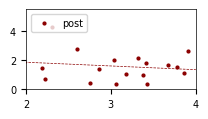

In [56]:
time_to_plot = [0.08, 0.12] #N100
# time_to_plot = [0.025, 0.06] #P50
ch_to_plot = ['Fz', 'FCz', 'Cz', 'F1', 'FC1', 'C1', 'C2', 'FC2', 'F2']
#ch_to_plot = ['Fz']
ch_idx = ch_index(ch_to_plot)
periods =['post']
time_idx = time_index_custom(time_to_plot, erp_times)

# corr_df['diff_tocorr'] = corr_df['diff'].apply(lambda x: np.mean(x[ch_idx, time_idx]))
# corr_df['diff_tocorr'] = corr_df['diff'].apply(lambda x: np.min(np.abs(x[ch_idx, time_idx[0]:time_idx[1]].mean(axis = 0))))
corr_df['diff_tocorr'] = corr_df['diff'].apply(lambda x: np.max(np.abs(x[ch_idx, time_idx[0]:time_idx[1]].mean(axis = 0))))


fig = plt.figure(figsize = (1.7, 0.8))
ax = fig.add_axes([0,0,1,1]) 

for period in periods:
# for period in ['pre']:
    if period == 'pre':
        color = 'darkblue'
        markerfacecolor = 'none' 
    elif period == 'post':
        color = 'darkred'
        markerfacecolor = color
    #correlation between differences and training performance
    corr_df_per = corr_df.query(f'period == "{period}"')

    #plot points
    plt.scatter(corr_df_per['score'], corr_df_per['diff_tocorr'], color = color, facecolors = markerfacecolor, label= period)
    #pearson corr
    print(pearsonr(corr_df_per['score'], corr_df_per['diff_tocorr']))

    # Generate the regression line
    slope, intercept, r_value, p_value_corr, std_err = stats.linregress(corr_df_per['score'], corr_df_per['diff_tocorr'])
    x = np.linspace(0, 4, 100)
    y = slope * x + intercept
    # plt.plot(x, y, label=f'R={r_value:.3f}, p = {p_value_corr:.3f}', linestyle = '--', color = color)
    plt.plot(x, y, linestyle = '--', color = color)


plt.xlim(2,4)
plt.ylim(0,5.5e-6)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 1e6:.1f}'))  # Convert to µV
# plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x * 1e6)}'))  # Convert to µV as integer


plt.xticks([2,3,4], labels= [2,3,4])
# plt.xticks([])
plt.yticks([0, 2e-6, 4e-6], labels = ['0', '2', '4'])

plt.legend(loc = 'upper left')
plt.tight_layout()

plt.savefig(f'./figures/corr_mus_{period}_P100.svg')


## Fig 6D (pre and post alone): Comparison over channels
(no bootstrapping here)

In [57]:
#utils for t-tests 

def invert_p_values(p_values_arr):
    """ 
    Transforms an arr of p values to prepare for plotting using mne.viz.plot_topomap
    Inverts the p values (replace x with 1-x) so that smaller p values 
    Makes all insignificant p values 0 so that when inverted, it shows up as white in the topomap

    p_values_arr: a 1d array of p-values
    returns: p_values_inv


    """
    p_values_inv = [1-x if x <0.05 else 0 for x in p_values_arr]
    return p_values_inv

def t_over_channels(array, fdr = True):
    """
    takes a difference array of size n_subs, n_ch (64 expected) and tests whether the differences are sigificantly different from 0

    ---
    returns:
    t: test statistic of size 64, one for each channel
    p: test statistic of size 64
    """
    t_values = []
    p_values = []
    
    for ch in range(64):
        diff_to_test = array[:, ch]
        t, p = wilcoxon_1samp(diff_to_test)
        t_values.append(t)
        p_values.append(p)


    t_values = np.array(t_values)
    p_values = np.array(p_values)
    
    if fdr: 
        p_values = fdrcorrection(p_values)[1]
    
    
    return t_values, p_values


def p_mask(diffs, p_values):

    """ 
    masks differences between two conditions so that only significant differences are plotted on the topomap
    diffs: 1d array
    p_values: 1d array of same size
    """
    assert diffs.shape == p_values.shape, 'diffs and p-values should be the same shape'
    diffs_masked = diffs.copy()
    diffs_masked[p_values>0.05] = 0
    return diffs_masked

/var/folders/jq/t9k2fgpx515flrs5403k2gf80000gn/T/ipykernel_61484/1146447895.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


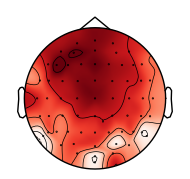

In [ ]:
#stats over channels

period = 'pre'

#take peak value over a time window 
time_to_plot = [0.025, 0.06] #P50
# time_to_plot = [0.08, 0.12] #N100

time_idx = time_index_custom(time_to_plot, erp_times)
diffs_fo_all = np.stack(corr_df.query(f'period == "{period}"')['diff'].values)

if time_to_plot == [0.08, 0.12]:
    diffs_fo = np.min(diffs_fo_all[:, :64, time_idx[0]:time_idx[1]], axis = 2)
elif time_to_plot == [0.025, 0.06]:
    diffs_fo = np.max(diffs_fo_all[:, :64, time_idx[0]:time_idx[1]], axis = 2)
_, p_fo = t_over_channels(diffs_fo, fdr = True)


#calculate differences
diffs_fo_t = diffs_fo.mean(axis = 0)
diffs_fo_t = p_mask(diffs_fo_t, p_fo)
diffs_fo_t_abs = np.abs(diffs_fo_t)

info = load_ep_info()

fig = plt.figure(figsize=(1.7,1.7))  # set the exact output size
ax = fig.add_axes([0, 0, 1, 1])   

im1, _ = mne.viz.plot_topomap(diffs_fo_t_abs, info, axes = ax, show=False, vlim=(0, 1.2e-6))


plt.savefig(f'./figures/fo_topo_{period}_{time_to_plot}.svg', transparent = True)
plt.tight_layout()

In [28]:
# #stats over channels with bootstrapping
 
# period = 'pre'
# time_to_plot = 0.06



# time_idx = time_index_custom([time_to_plot], erp_times)[0]
# diffs_fo= np.stack(corr_df.query(f'period == "{period}"')['diff'].values)[:, :64, time_idx]
# _, p_fo = t_over_channels(diffs_fo)

# #calculate differences
# diffs_fo_t = diffs_fo.mean(axis = 0)
# diffs_fo_t = p_mask(diffs_fo_t, p_fo)
# diffs_fo_t_abs = np.abs(diffs_fo_t)

# info = load_ep_info()

# # fig, axes = plt.subplots(figsize=(8,4))
# # im1, _ = mne.viz.plot_topomap(diffs_fo_t_abs, info, axes = axes, show=False, vlim=(0, 1.2e-6))

# # im1, _ = mne.viz.plot_topomap(diffs_fo_t, info, axes = axes, show=False)

# fig = plt.figure(figsize=(1.7,1.7))  # set the exact output size
# ax = fig.add_axes([0, 0, 1, 1])         # make axes fill the figure

# # for coll in ax.collections:
# #     if hasattr(coll, "set_linewidth"):
# #         coll.set_linewidth(0.1)

# im, _ = mne.viz.plot_topomap(
#     diffs_fo_t_abs, info, axes=ax, show=False, vlim=(0, 1.2e-6)
# )
# # cbar = plt.colorbar(im1, ax=ax, orientation='horizontal')
# # cbar.ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 1e6:.1f}'))  # Convert scale from V to µV
# # cbar.set_label(r'Amplitude ($\mu$V)')
# # cbar.ax.tick_params()

# # fig.suptitle(f'{period} {time_to_plot} s'+"{}")
# # plt.tight_layout()

# plt.savefig(f'./figures/fo_topo_{time_to_plot}_{period}.svg', transparent=True)

## Fig 3A, 6A: Compare first and other ERPs directly

In [29]:
# #comparing firsts and others in all periods
# mean_firsts = epochs_df_firsts['evokeds'].mean(axis=0)[ch_idx].flatten()
# sem_firsts = sem(epochs_df_firsts['evokeds'],axis=0)[ch_idx].flatten()

# mean_others = epochs_df_others['evokeds'].mean(axis=0)[ch_idx][0].flatten()
# sem_others = sem(epochs_df_others['evokeds'],axis=0)[ch_idx].flatten()

# plt.figure(figsize=(10, 6))
# col = 'darkslateblue'

# # Plot the first dataset
# plt.plot(erp_times, mean_firsts, label='firsts', color=col)
# plt.fill_between(erp_times, mean_firsts - sem_firsts, mean_firsts + sem_firsts, color = col, alpha=0.6)

# # Plot the other dataset
# plt.plot(erp_times, mean_others, label='others', color=col, alpha = 0.6)
# plt.fill_between(erp_times, mean_others - sem_others, mean_others + sem_others, color=col, alpha=0.3)

# # Add labels, legend, and grid
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude (µV)')
# plt.title(f'ERP first and others, all participants, pre and post')
# plt.hlines(0, -0.5, 0.5, color = 'black', linewidth = 0.7)
# plt.vlines(0, np.min(mean_firsts), np.max(mean_firsts), color = 'black', linestyles= '--')
# plt.legend()
# plt.show()


In [30]:
def p_times(arrays_to_compare, channels = 'all', test = wilcoxon, fdr = False, fdr_idx = None):
    """ 
    calculate p values of differences between two arrays with erps

    arrays_to_compare: a list of 2 arrays to compare. For example [test_pre, test_post]. 
        Each array should be shape n_subs x n_channels x n_timepoints

    test: which stat test to use. t-test_ind, wilcoxon, etc.
    fdr: whether to apply fdr correction to the p values
    fdr_range: list, min and max time in seconds to consider for fdr correction. 
        p-value for timepoints outside range will be set to 1 
    ---
    returns: a list of p values, one p value for each time point
    
    """
    p_values = []

    assert arrays_to_compare[0].shape == arrays_to_compare[1].shape, 'arrays to compare should be the same shape'
    assert arrays_to_compare[0].shape[1] == 64 or arrays_to_compare[0].shape[1], 'arrays to compare should have 64 channels'
    
    
    if channels == 'all':
        print('Calculating p-value over mean of all channels')
        array1 = arrays_to_compare[0][:, 0:64]
        array2 = arrays_to_compare[1][:, 0:64]
    elif type(channels) == list:
        print(f'Calculating p-value over {channels}')
        p_ch_idx = ch_index(channels)
        array1 = arrays_to_compare[0][:, p_ch_idx]
        array2 = arrays_to_compare[1][:, p_ch_idx]

        
    else:
        print('Channels should be provided in a list. No p-values computed.')
        exit

    print('evokeds array shape', array1.shape)
    for timepoint in range(0, arrays_to_compare[0].shape[2]):
        res = test(array1.mean(axis = 1)[:, timepoint], array2.mean(axis = 1)[:, timepoint])
        p_values.append(res.pvalue)
    
    if fdr:
        if fdr_idx is None:
            p_values = fdrcorrection(p_values)[1]
        else: 
            #make sure fdr idx is within time range
            assert all(0 <= idx < len(p_values) for idx in fdr_idx), 'fdr_idx out of range of timepoints'

            p_values_range = p_values[fdr_idx[0]:fdr_idx[1]]
            p_values_range = fdrcorrection(p_values_range)[1]
            p_values = np.ones_like(np.array(p_values))
            p_values[fdr_idx[0]:fdr_idx[1]] = p_values_range

    return p_values

(72, 129)


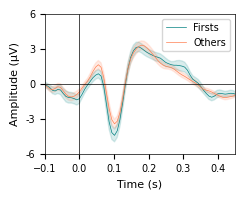

In [32]:
#comparing firsts and others in only one period
ch_to_plot = 'Fz'
ch_idx = ch_index([ch_to_plot])
period = 'post'
t_over_time = False

epochs_df_firsts_per = epochs_df_firsts.query(f'period == "{period}" ')
epochs_df_others_per = epochs_df_others.query(f'period == "{period}"')

print(epochs_df_firsts_per.iloc[0]['evokeds'].shape)
mean_firsts = epochs_df_firsts_per['evokeds'].mean(axis=0)[ch_idx].flatten()
sem_firsts = sem(epochs_df_firsts_per['evokeds'],axis=0)[ch_idx].flatten()

# # Calculate the mean and SEM for the other dataset
mean_others = epochs_df_others_per['evokeds'].mean(axis=0)[ch_idx].flatten()
sem_others = sem(epochs_df_others_per['evokeds'],axis=0)[ch_idx].flatten()


fig = plt.figure(figsize=(1.9, 1.4))
ax = fig.add_axes([0,0,1,1]) 

# Plot the first dataset
plt.plot(erp_times, mean_firsts, label='Firsts', color=firsts_color)
plt.fill_between(erp_times, mean_firsts - sem_firsts, mean_firsts + sem_firsts, color = firsts_color, alpha=0.15)

# Plot the other dataset
plt.plot(erp_times, mean_others, label='Others', color=others_color)
plt.fill_between(erp_times, mean_others - sem_others, mean_others + sem_others, color=others_color, alpha=0.15)


#Plot stars over time
if t_over_time:
    #run stats over timepoints
    firsts_ev = np.stack(epochs_df_firsts_per['evokeds'])
    others_ev = np.stack(epochs_df_others_per['evokeds'])
    p_exploratory = p_times([firsts_ev, others_ev], 
                            channels = [ch_to_plot], 
                            test = wilcoxon, 
                            fdr = True, 
                            fdr_idx=time_index_custom([0, 0.3], erp_times))


    sig_idx = np.where(np.array(p_exploratory) < 0.05)
    sig_times = erp_times[sig_idx]

    plt.plot(sig_times, np.ones_like(sig_times) * 5.5e-6, '*', color = 'grey', markersize = 7)
    
# np.ones_like(sig_times) * 5e-6

# Add labels, legend, and grid
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
# plt.title(f'ERP first and others, {period} training {ch_to_plot}')
plt.hlines(0, -0.5, 0.5, color = 'black')
plt.vlines(0, -6.5e-6, 6e-6, color = 'black')

plt.ticklabel_format(style='plain', axis='y')  # Disable scientific notation
# plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 1e6:.1f}'))  # Convert to µV
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x * 1e6)}'))  # Convert to µV as integer

plt.xlim(-0.1, 0.45)
plt.ylim(-6e-6, 6e-6)
plt.yticks([-6e-6, -3e-6, 0, 3e-6, 6e-6], labels=['-6', '-3', '0', '3', '6'])
# plt.xticks(fontsize = xtick_fontsize)
# plt.yticks(fontsize = xtick_fontsize)
plt.legend(loc = 'upper right')

plt.savefig(f'./figures/fo_ERP_{period}_{ch_to_plot}.svg')
# plt.savefig(f'./figs/fo_ERP_{period}.png')


## Fig 6B: compare delta first-others pre vs post

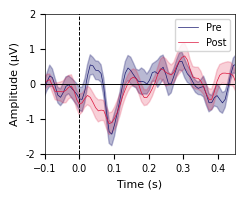

In [33]:
#compare difference between first and others in each epoch
t_over_time = False
diff_colours = ['midnightblue', 'crimson']

#find average diff value
corr_df_pre = corr_df.query(f"period == 'pre'")['diff']
corr_df_post = corr_df.query(f"period == 'post'")['diff']
diff_values_pre = np.array([row[ch_idx] for row in corr_df_pre]).mean(axis = 0).mean(axis=0) 
diff_sem_pre = sem(np.array([row[ch_idx] for row in corr_df_pre]).mean(axis = 1))
diff_values_post =  np.array([row[ch_idx] for row in corr_df_post]).mean(axis = 0).mean(axis=0) 
diff_sem_post = sem(np.array([row[ch_idx] for row in corr_df_post]).mean(axis = 1))

fig=plt.figure(figsize=(1.9, 1.4))
ax = fig.add_axes([0,0,1,1])

plt.plot(erp_times, diff_values_pre, color = diff_colours[0], label = 'Pre')
plt.fill_between(erp_times, diff_values_pre-diff_sem_pre, diff_values_pre+diff_sem_pre, color = diff_colours[0], alpha = 0.3)
plt.plot(erp_times, diff_values_post, color = diff_colours[1],label = 'Post')
plt.fill_between(erp_times, diff_values_post-diff_sem_post, diff_values_post+diff_sem_post, color = diff_colours[1], alpha = 0.2)



if t_over_time:
    pre_diff = np.stack(corr_df_pre)
    post_diff = np.stack(corr_df_post)

    p_exploratory = p_times([pre_diff, post_diff], 
                        channels = [ch_to_plot], 
                        test = wilcoxon, 
                        fdr = False, 
                        fdr_idx=time_index_custom([0, 0.1], erp_times))


    sig_idx = np.where(np.array(p_exploratory) < 0.05)
    sig_times = erp_times[sig_idx]

    plt.plot(sig_times, np.ones_like(sig_times) * 1.5e-6, '*', color = 'grey', markersize = 7)
    
    

# Add labels, legend, and grid
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
# plt.title(f'ERP first and others, all participants, {period} training')
plt.hlines(0, -0.5, 0.5, color = 'black', linewidth = 0.7)
plt.vlines(0, -6.5e-6, 5e-6, color = 'black', linestyles= '--', linewidth = 0.7)

plt.legend(loc = 'upper right')

plt.ticklabel_format(style='plain', axis='y')  # Disable scientific notation
# plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 1e6:.1f}'))  # Convert to µV
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x * 1e6)}'))  # Convert to µV as integer

plt.xlim(-0.1, 0.45)
plt.ylim(-2e-6, 2e-6)
# plt.xticks(fontsize = xtick_fontsize)
# plt.yticks(fontsize = xtick_fontsize)

plt.savefig('./figures/fo_prepost_diff.svg')

## Figure 6D (post-pre): channel topomap

/var/folders/jq/t9k2fgpx515flrs5403k2gf80000gn/T/ipykernel_61484/773935097.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


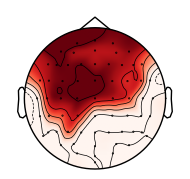

In [60]:
#stats over channels

time_to_plot = 0.06

time_idx = time_index_custom([time_to_plot], erp_times)[0]

diff_pre = np.stack(corr_df.query(f"period == 'pre'")['diff'])[:, :64, time_idx]
diff_post = np.stack(corr_df.query(f"period == 'post'")['diff'])[:, :64, time_idx]
diff_diff = diff_post-diff_pre


_, p_pp = t_over_channels(diff_diff)

#calculate differences
diffs_pp_t = diff_diff.mean(axis = 0)
diffs_pp_t = p_mask(diffs_pp_t, p_pp)
diffs_pp_t_abs = np.abs(diffs_pp_t)

info = load_ep_info()
fig = plt.figure(figsize=(1.7,1.7))  # set the exact output size
ax = fig.add_axes([0, 0, 1, 1])         # make axes fill the figure

im1, _ = mne.viz.plot_topomap(diffs_pp_t_abs, info, axes = ax, show=False, vlim =( 0, 1.2e-6))

# cbar = plt.colorbar(im1, ax=axes, orientation='horizontal')
# cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 1e6:.1f}'))  # Convert scale from V to µV

# fig.suptitle(f'(first - others) pre vs (first - others) post, {time_to_plot} s')
plt.savefig(f'./figures/fo_topo_diff_{time_to_plot}.svg')
plt.tight_layout()

In [35]:
# t_values = []
# p_values = []
# diffs = []


# for ch in range(64):
#     diff_to_test = [x[ch, time_idx] for x in corr_df_per['diff'].values]
#     t, p = wilcoxon_1samp(diff_to_test)
#     t_values.append(t)
#     p_values.append(p)
#     diffs.append(np.mean(diff_to_test))

# p_values = fdrcorrection(p_values)[1]
# p_values_inv = invert_p_values(p_values)


# diffs_toplot = diffs.copy()
# diffs_toplot = np.array(diffs_toplot)
# # insig_idx = np.where(p_values<0.05)[0]
# diffs_toplot[p_values>0.05] = 0


# info = load_ep_info()

# fig, axes = plt.subplots(figsize=(8,4))
# im1, _ = mne.viz.plot_topomap(diffs_toplot, info, axes = axes, show=False)


# fig.suptitle(f'{period} {time_to_plot} s')
# plt.tight_layout()
# plt.savefig(f'./figs/blank_topo.svg')

In [36]:
# period = 'pre'

# epochs_df_firsts_per = epochs_df_firsts.query(f'period == "{period}"')
# epochs_df_others_per = epochs_df_others.query(f'period == "{period}"')

# mean_firsts = epochs_df_firsts_per['evokeds'].mean(axis=0)[ch_idx]
# sem_firsts = sem(epochs_df_firsts_per['evokeds'],axis=0)[ch_idx]

# # # Calculate the mean and SEM for the other dataset
# mean_others = epochs_df_others_per['evokeds'].mean(axis=0)[ch_idx]
# sem_others = sem(epochs_df_others_per['evokeds'],axis=0)[ch_idx]

# plt.figure(figsize=(10, 6))
# col = 'darkslateblue'

# # Plot the first dataset
# plt.plot(erp_times, mean_firsts, label='firsts', color=col)
# plt.fill_between(erp_times, mean_firsts - sem_firsts, mean_firsts + sem_firsts, color = col, alpha=0.6)

# # Plot the other dataset
# plt.plot(erp_times, mean_others, label='others', color=col, alpha = 0.6)
# plt.fill_between(erp_times, mean_others - sem_others, mean_others + sem_others, color=col, alpha=0.3)

# # Add labels, legend, and grid
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude (µV)')
# plt.title(f'ERP first and others, all participants, {period} training')
# plt.hlines(0, -0.5, 0.5, color = 'black', linewidth = 0.7)
# plt.vlines(0, np.min(mean_firsts), np.max(mean_firsts), color = 'black', linestyles= '--')
# plt.legend()
# plt.show()


## Fig 6C: Anova: pre vs post, first vs others

In [37]:
# time_to_plot = [0.09, 0.11] #N100 if we want to be consistent with topomap 
# time_to_plot = [0.08, 0.12] #N100
# time_to_plot = [0.045, 0.055] #P50, significant if 0.055, 0.065
time_to_plot = [0.025, 0.06]
# time_to_plot = [0, 0.5] #peak to peak

peakfinder = np.max

time_idx = time_index_custom(time_to_plot, erp_times)

In [38]:


#combine epoch data
ch_to_test = ['Fz', 'FCz', 'Cz', 'F1', 'FC1', 'C1', 'C2', 'FC2', 'F2']
ch_idx = ch_index(ch_to_test)
anova_cols = ['subject', 'period', 'epochtype', 'evokeds']
ev_df_combined = pd.concat([epochs_df_firsts[anova_cols], epochs_df_others[anova_cols]])
#ev_df_combined['amp_attime'] = ev_df_combined['evokeds'].apply(lambda x: np.mean(x[ch_idx, time_idx]))

ev_df_combined['amp_attime'] = ev_df_combined['evokeds'].apply(lambda x: peakfinder(x[ch_idx, time_idx[0]:time_idx[1]].mean(axis = 0)))

In [39]:
#run anova
anova_res = rm_anova(data = ev_df_combined, dv = 'amp_attime', within = ['period', 'epochtype'], subject = 'subject')
anova_res

/opt/anaconda3/envs/am-eeg/lib/python3.12/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/opt/anaconda3/envs/am-eeg/lib/python3.12/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,period,9.689693e-15,1,17,9.689693e-15,0.012491,0.912322,0.912322,0.000087,1.0
1,epochtype,4.460604e-14,1,17,4.460604e-14,0.153413,0.700161,0.700161,0.000402,1.0
2,period * epochtype,5.384273e-12,1,17,5.384273e-12,10.447295,0.004896,0.004896,0.046313,1.0


/opt/anaconda3/envs/am-eeg/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/am-eeg/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/am-eeg/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/am-eeg/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

post_firsts vs. post_others: Wilcoxon test (paired samples), P_val:1.084e-01 Stat=4.800e+01
pre_firsts vs. pre_others: Wilcoxon test (paired samples), P_val:8.392e-04 Stat=1.400e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post: Wilcoxon test (paired samples), P_val:6.247e-01 Stat=3.010e+02


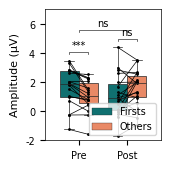

In [40]:
#plot anova comparison

palette= {
    'firsts': firsts_color,  # Adjust alpha for transparency
    'others': others_color
}
plt.figure(figsize=(1.5,1.7))
flierprops = dict(marker='o', markersize=1, linestyle='none', markerfacecolor='gray', alpha=0.6)


ax = sns.boxplot(data = ev_df_combined, 
                 x = 'period', 
                 y = 'amp_attime', 
                 hue = 'epochtype', 
                 dodge = True, 
                 palette = palette, flierprops=flierprops
                 )

for period in ev_df_combined['period'].unique():
    if period == 'pre':
        x_pos =  [-0.2, 0.2]
    elif period == 'post':
        x_pos = [0.8, 1.2]

    for subject in ev_df_combined['subject'].unique():

        ev_toplot = ev_df_combined.query(f'subject == "{subject}" and period == "{period}"')
        amp_firsts = ev_toplot.query(f'epochtype == "firsts"')['amp_attime'].values[0]
        amp_others = ev_toplot.query(f'epochtype == "others"')['amp_attime'].values[0]
        
    
        ax.plot(x_pos, [amp_firsts, amp_others], color = 'black', marker = 'o', markersize = 1)

#Compare epoch typew within condition
pairs = [(("pre", "firsts"), ("pre", "others")),
         (("post", "firsts"), ("post", "others"))]
annot = Annotator(ax, pairs, data=ev_df_combined, x='period', y='amp_attime', hue='epochtype')
annot.configure(test='Wilcoxon', text_format='star', loc='inside', verbose=2,
                 fontsize = mpl.rcParams['xtick.labelsize'],
                    line_width = mpl.rcParams['lines.linewidth'],)
annot.apply_and_annotate()


#Pre vs post main effect
pairs = [("pre", "post")]
annot = Annotator(ax, pairs, data=ev_df_combined, x='period', y='amp_attime')
annot.configure(test='Wilcoxon', text_format='star', loc='inside', verbose=2, 
                 fontsize = mpl.rcParams['xtick.labelsize'],
                    line_width = mpl.rcParams['lines.linewidth'],)
annot.apply_and_annotate()


plt.ticklabel_format(style='plain', axis='y')  # Disable scientific notation
# plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 1e6:.1f}'))  # Convert to µV
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x * 1e6)}'))  # Convert to µV as integer

ax.set_ylabel(f'Amplitude (µV)')
ax.set_xticks([0,1], ['Pre', 'Post'])
ax.set_yticks([-2e-6, 0, 2e-6, 4e-6, 6e-6], labels=['-2', '0', '2', '4', '6'])
# ax.set_yticks([-15e-6, -10e-6, -5e-6, 0, 5e-6], labels=['-15','-10', '-5', '0', '5'])
# ax.set_title(f'ERP amplitude at {time_to_plot} s, {ch_to_test}')
ax.set_xlabel('')
# ax.tick_params(labelsize = 15)
# ax.legend(title = '', loc = 'lower right')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, [label.capitalize() for label in labels], title='', loc='lower right')
plt.ylim(-2e-6,7e-6)

plt.savefig(f'./figures/erp_amp_prepost_{time_to_plot}.svg', transparent=True)

In [41]:
ev_df_combined

,subject,period,epochtype,evokeds,amp_attime
0,01,pre,firsts,"[[4.4397462041922234e-08, -3.275097806651882e-...",7.250194e-07
1,01,post,firsts,"[[-9.076364749197727e-07, -1.1968002969824103e...",7.039261e-07
2,04,pre,firsts,"[[-1.2575795533247138e-06, -1.6142838250648457...",2.036891e-06
3,04,post,firsts,"[[2.2947391768597795e-08, 2.433407157230828e-0...",-5.474138e-08
4,05,pre,firsts,"[[-6.56134246574371e-07, -3.1454180020344485e-...",-1.253140e-06
...,...,...,...,...,...
31,18,post,others,"[[3.4627126531879236e-07, 3.545713542173283e-0...",2.653454e-06
32,19,pre,others,"[[4.971439142984361e-07, 4.996551582559221e-07...",2.262392e-06
33,19,post,others,"[[-1.3816863986886137e-07, 2.3886894015189544e...",3.459855e-06
34,20,pre,others,"[[9.403100893814339e-08, 9.123838527961722e-08...",7.839539e-07
